# Walmart : Prediction de ventes
L'objectif est de construire est un modèle de machine learning capable d'estimer les chiffres de ventes hebdomadaire de leurs magasin.
Le modèle leur permettra de comprendre comment le chiffre d'affaires est influencé par certains indicateurs et de les utilisé par la suite dans leur campagne marketing.

In [85]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

In [86]:
df = pd.read_csv("data/Walmart_Store_sales.csv")

## Analyse exploratoire des données (EDA)

In [87]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [88]:
display(f"Nb rows : {df.shape[0]}, Nb columns : {df.shape[1]}")

print("Describe : ")
display(df.describe(include="all", datetime_is_numeric=True))

print("Missing value %")
display(df.isna().sum() * 100 / len(df))

'Nb rows : 150, Nb columns : 8'

Describe : 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


Missing value %


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

La date est en `string` donc on la converti en `datetime`

In [89]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")

On regarde les correlation entre les differente colonne pour savoir si il y a des colonnes redondante (dont la corrélation == 1)

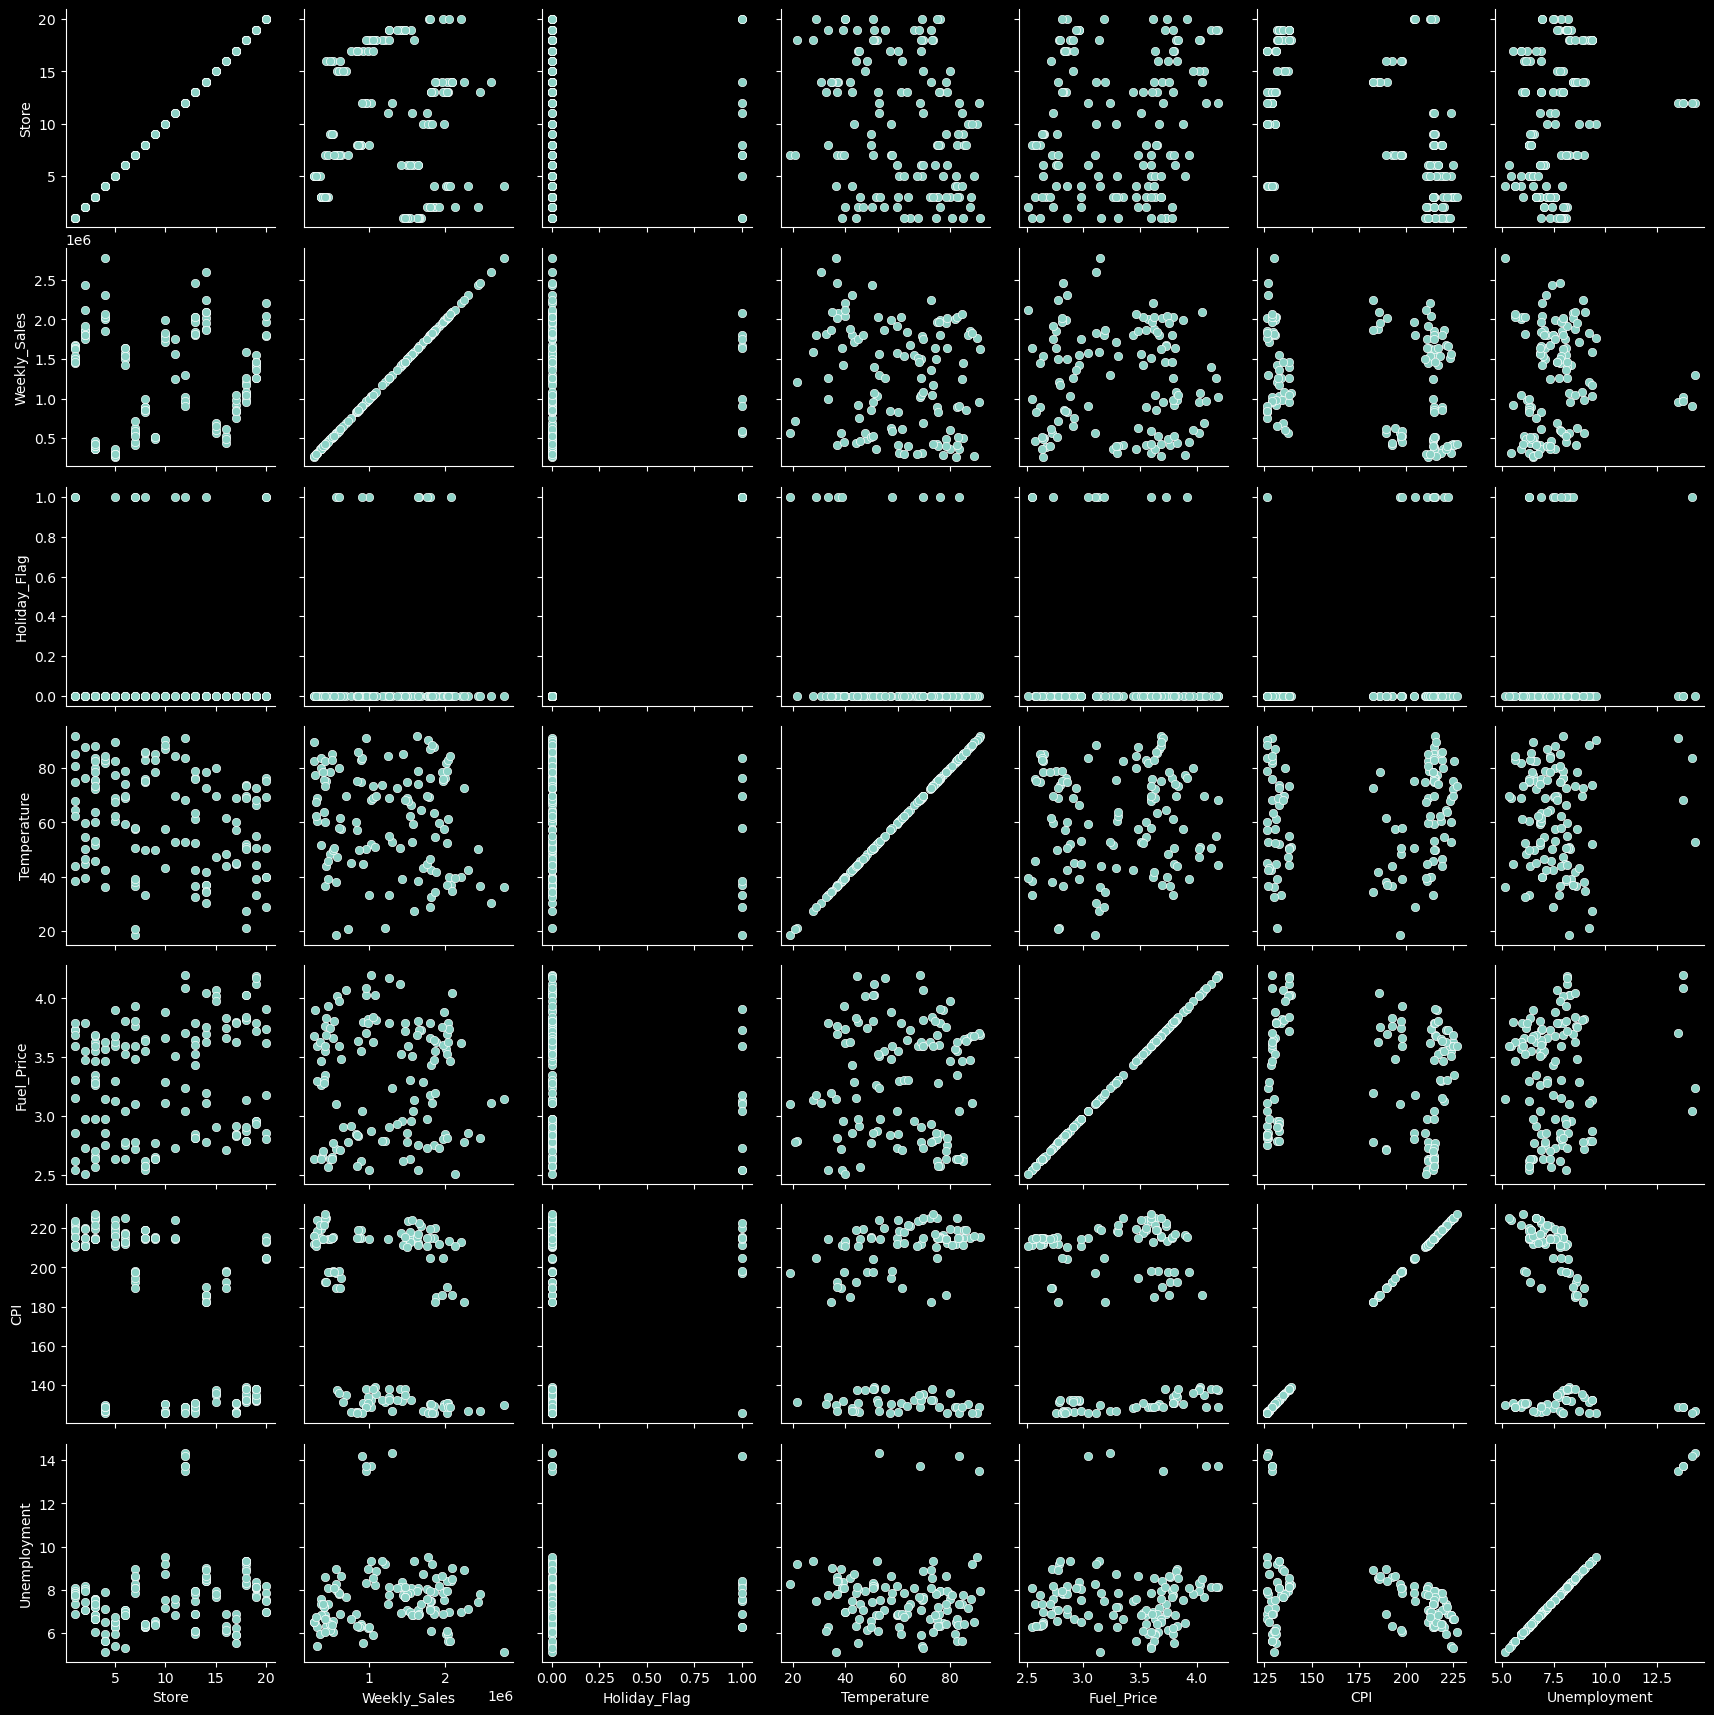

In [90]:
g = sns.PairGrid(df)
g.map(sns.scatterplot)

<Axes: >

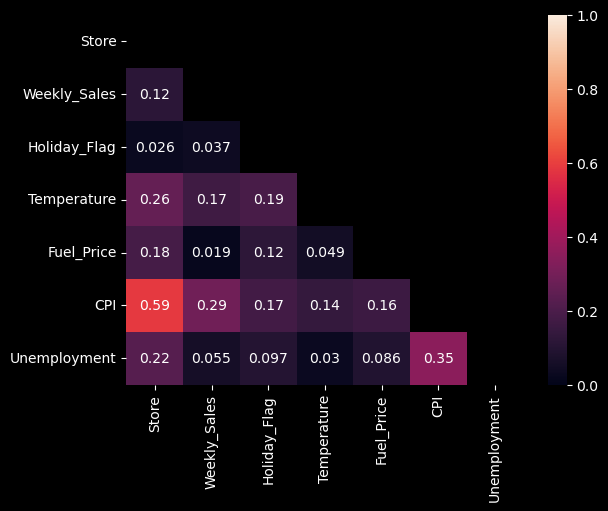

In [91]:
corr = df.corr(numeric_only=True).abs()

heatmap_mask = np.triu(corr)

sns.heatmap(corr, annot=True, vmin=0, vmax=+1, mask=heatmap_mask)


Il n'y a pas de correlation parfaite donc il n'y a pas de colonne en doublon.

## Preprocessing

### Colonnes
On ne supprime aucune colonne car aucune ne sont des uid, ni ont un pourcentage de valeurs de manquantes > 60%.
Pour la date, on créée plusieurs colonnes pour l'exploiter (année, mois, jour, jour de la semaine).

### Lignes
On supprimes les lignes avec des outliers, ici on garde une fênetre à 3 écart-type et les lignes où la target est manquante

### Imputation, normalisation, encoding
On gère l'imputation, la normalisation et l'encoding via la librairi scikit-learn.

Variables categorielles : Store, Holiday_flag

Variables numérique : Temperature, Fuel_price, CPI, Unemployment, Year, Month, Day, DayOfWeek

In [92]:
df["Year"] = df["Date"].dt.strftime('%Y')
df["Month"] = df["Date"].dt.strftime('%m')
df["Day"] = df["Date"].dt.strftime('%d')
df["DayOfWeek"] = df["Date"].dt.strftime('%w')
df = df.drop("Date", axis=1)


# delete missing target
df = df.loc[df["Weekly_Sales"].isna() == False, :]

# delete outliers
outliers_column = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
for col in outliers_column:
    df = df.loc[(df[col].isna()) | ((df[col] > df[col].mean() - 3*df[col].std()) & (df[col] < df[col].mean() + 3*df[col].std())), :]

display(df.describe(include="all", datetime_is_numeric=True))
print("Missing value %")
display(df.isna().sum() * 100 / len(df))

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,DayOfWeek
count,131.000000,1.310000e+02,120.000000,117.000000,119.000000,120.000000,117.000000,113,113,113,113
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,12,30,1
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,06,12,5
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,14,10,113
mean,9.938931,1.257990e+06,0.066667,60.405897,3.302908,180.175755,7.399427,NaN,NaN,NaN,NaN
std,6.228663,6.577463e+05,0.250490,18.466740,0.475435,39.723167,0.994117,NaN,NaN,NaN,NaN
min,1.000000,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000,NaN,NaN,NaN,NaN
25%,4.000000,5.842439e+05,0.000000,44.820000,2.824000,132.579257,6.664000,NaN,NaN,NaN,NaN
50%,9.000000,1.366396e+06,0.000000,61.790000,3.435000,197.655672,7.368000,NaN,NaN,NaN,NaN
75%,16.000000,1.809576e+06,0.000000,75.540000,3.708500,214.904838,8.099000,NaN,NaN,NaN,NaN


Missing value %


Store            0.000000
Weekly_Sales     0.000000
Holiday_Flag     8.396947
Temperature     10.687023
Fuel_Price       9.160305
CPI              8.396947
Unemployment    10.687023
Year            13.740458
Month           13.740458
Day             13.740458
DayOfWeek       13.740458
dtype: float64

Après la suppression des lignes des outliers et de la target manquante, il nous reste 131 lignes que l'on va pouvoir imputer, normaliser et encoder.

In [93]:
target_name = "Weekly_Sales"

Y = df.loc[:,target_name]
X = df.drop(target_name, axis = 1)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=0)

numeric_features = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "Year", "Month", "Day", "DayOfWeek"]
categorical_features = ["Store", "Holiday_Flag"]

numeric_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='median')),
  ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
  ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
])


preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Baseline Model

On effectue un test de model simple en prenant toutes les feature, et on regarde ce score de base que l'on essaiera par la suite de d'améliorer.

In [94]:
base_model = LinearRegression()
base_model.fit(X_train, Y_train) 

print(f"R2 score on training set :  {base_model.score(X_train, Y_train)}")
print(f"R2 score on test set :  {base_model.score(X_test, Y_test)}")

R2 score on training set :  0.9735254377423802
R2 score on test set :  0.9452414111819046
